In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import datetime

In [3]:
color_scheme1 = plt.cm.get_cmap('tab20c')
color_scheme2 = plt.cm.get_cmap('tab20c')

In [4]:
fig_size = (13, 8)

In [5]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(datetime.datetime.now())
print(now)

2021-03-15 17:32:20.111904
20210315_173220


In [6]:
xl_writer = pd.ExcelWriter(f"covid19_swiss_data_{now}.xlsx")

In [7]:
def pivot_data(data_frame, column_name):
    """
    Function to extract the data by column type
    
    return a dataframe
    """
    data_frame.loc[data_frame['ncumul_conf'] == 0.0, column_name] = np.nan
    pivot = pd.DataFrame(pd.pivot_table(data_frame, 
                                        values=column_name, 
                                        index='date', 
                                        columns=['abbreviation_canton_and_fl'], 
                                        aggfunc=np.sum, 
                                        dropna=True))
    new_df = pd.DataFrame(pivot.to_records()).drop(columns="FL")
    for col in new_df.columns[1:]:
        new_df.loc[new_df[col] == 0.0, col] = np.nan
    new_df.fillna(method='ffill', inplace=True)
    new_df['CH'] = new_df.sum(axis=1)
    return new_df

In [8]:
def add(df1, df2, country):
    df = pd.concat([df1[country], df2[country]], axis=1)
    df.country = country
    df.columns = ["cases", "deaths"]
    df["daily_cases"] = df["cases"].diff()
    df.loc[df["cases"].isna(), "cases"] = 0
    df["daily_cases_s"] = signal.savgol_filter(df["cases"], 9, 3, deriv=1)
    df["daily_death"] = df["deaths"].diff()
    df.loc[df["deaths"].isna(), "deaths"] = 0
    df["daily_death_s"] = signal.savgol_filter(df["deaths"], 9, 3, deriv=1)
    return df

In [9]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)

# Data

data from 

https://github.com/openZH/covid_19 for the data about the covid-19

https://github.com/daenuprobst/covid19-cases-switzerland for the demography and geographical data 

http://www.web.statistik.zh.ch/covid19_dashboard/index.html#/ status for each canton

In [10]:
url = "https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/demographics.csv"

In [11]:
demography = pd.read_csv(url, index_col="Canton")
# demography = pd.read_csv("demography.csv", index_col="canton")

In [12]:
demography.to_excel(xl_writer, "Demographic data")

In [13]:
# url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv"
url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total_v2.csv"

In [14]:
df = pd.read_csv(url)

In [15]:
df.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'new_hosp', 'current_hosp', 'current_icu',
       'current_vent', 'ncumul_released', 'ncumul_deceased', 'source',
       'current_isolated', 'current_quarantined',
       'current_quarantined_riskareatravel', 'current_quarantined_total'],
      dtype='object')

In [16]:
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

In [17]:
df.loc[df['ncumul_conf'] == 0.0, 'ncumul_conf'] = np.nan

In [18]:
df.to_excel(xl_writer, sheet_name="Raw", freeze_panes=(1, 1))

# Data extraction

### Extract cases

In [19]:
cases = pivot_data(df, 'ncumul_conf')

In [20]:
cases["day_of_year"] = cases["date"].dt.dayofyear

In [21]:
cases.set_index(["date", "day_of_year"], inplace=True)

In [22]:
cases.to_excel(xl_writer, "Cases", freeze_panes=(1, 1))

In [23]:
cases_by_day = cases.diff()

In [24]:
cases_by_day.to_excel(xl_writer, "Cases by day", freeze_panes=(1,1))

### Extract Deaths

In [25]:
deaths = pivot_data(df, 'ncumul_deceased')

In [26]:
deaths["day_of_year"] = deaths["date"].dt.dayofyear

In [27]:
deaths.set_index(["date", "day_of_year"], inplace=True)

In [28]:
deaths.to_excel(xl_writer, "Deceased Cumulative", freeze_panes=(1,1))

In [29]:
# First columns is the date
daily_deaths = deaths.diff()

In [30]:
daily_deaths.to_excel(xl_writer, "Daily Deaths", freeze_panes=(1,1))

### Extract Summary

In [31]:
max_cases = pd.to_numeric(cases.max(), downcast="integer").reset_index(name="cases")

In [32]:
max_cases.set_index(keys="index", inplace=True)

In [33]:
max_cases.index.name = "Canton"

In [34]:
max_death = pd.to_numeric(deaths.max(), errors='coerce', downcast="integer").reset_index(name="deaths")

In [35]:
max_death.set_index(keys="index", inplace=True)

In [36]:
max_death.index.name = "Canton"

In [37]:
max_death.loc[max_death["deaths"].isna(), "deaths"] = 0

In [38]:
df_summary = pd.concat([max_cases, 
                        max_death,
                        demography,
                       ], 
                       axis=1)

In [39]:
# df_summary.sort_values(by="cases", ascending=False, inplace=True)
df_summary.sort_index(inplace=True)

In [40]:
df_summary["death_rate"] = df_summary["deaths"] / df_summary["cases"] *100

In [41]:
df_summary["cases per 100'000"] = df_summary["cases"].astype('int64') * 100000 / df_summary["Population"]

In [42]:
df_summary["deaths per 100'000"] = df_summary["deaths"].astype('int64') * 100000 / df_summary["Population"]

In [43]:
df_sum = cases.tail(15).diff(14).iloc[-1].to_frame()

In [44]:
df_sum.index.name =  "Canton"

In [45]:
df_sum.columns = ["cases last 14 days"]

In [46]:
df_summary = pd.concat([df_summary, df_sum], axis=1)

In [47]:
df_summary["cases last 14 days by 100'000"] = df_summary["cases last 14 days"] * 100000 / df_summary["Population"]

In [48]:
df_summary.to_excel(xl_writer, "Summary", index=True, freeze_panes=(1, 1))

In [49]:
df_summary.sort_values("cases", ascending=False, inplace=True)

In [50]:
df_summary

,cases,deaths,Population,SettlementAreaHa,SettlementAreaKm2,Density,O65,O65P,Beds,BedsPerCapita,death_rate,cases per 100'000,deaths per 100'000,cases last 14 days,cases last 14 days by 100'000
Canton,,,,,,,,,,,,,,,
CH,565464,10118,8541410,NaN,NaN,2780.073699,0.191,1576463,23111,0.002706,1.789327,6620.265272,118.458194,14990.0,175.497956
ZH,90159,1294,1520968,37796.0,377.96,4024.150704,0.170,258565,4472,0.002940,1.435242,5927.738125,85.077398,2669.0,175.480352
VD,69827,933,799145,29940.0,299.40,2669.154977,0.164,131060,2268,0.002838,1.336159,8737.713431,116.749776,1556.0,194.708094
BE,54861,1013,1034977,41197.0,411.97,2512.263029,0.208,215275,3053,0.002950,1.846485,5300.697503,97.876571,1276.0,123.287764
GE,48798,705,495249,9416.0,94.16,5259.653781,0.164,81221,1506,0.003041,1.444731,9853.225347,142.352635,1252.0,252.802126
AG,37910,638,678207,23854.0,238.54,2843.158380,0.177,120043,1450,0.002138,1.682933,5589.738826,94.071574,1130.0,166.615797
SG,34938,685,507697,19408.0,194.08,2615.916117,0.183,92909,1565,0.003083,1.960616,6881.663669,134.922995,668.0,131.574542
VS,32225,755,343955,18463.0,184.63,1862.942100,0.196,67415,834,0.002425,2.342901,9368.958149,219.505459,779.0,226.483116
TI,28876,967,353343,15881.0,158.81,2224.941754,0.226,79856,1338,0.003787,3.348802,8172.229250,273.671758,853.0,241.408490


In [51]:
cantons = list(df_summary.index)[1:]

### Hospitalization

In [52]:
hosp = pivot_data(df, 'current_hosp')

In [53]:
hosp["day_of_year"] = hosp["date"].dt.dayofyear

In [54]:
hosp.set_index("date", inplace=True)

In [55]:
icu =  pivot_data(df, 'current_icu')

In [56]:
icu.set_index("date", inplace=True)

## Correlation Matrix

In [57]:
corr = df_summary.drop("CH").corr()

In [58]:
corr.to_excel(xl_writer, "Correlation Matrix")

In [59]:
xl_writer.close()

# Analysis Switzerland

In [60]:
cases.tail(10)

,Canton,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
date,day_of_year,,,,,,,,,,,,,,,,,,,,,
2021-03-06,65,37147.0,883.0,2867.0,54078.0,13807.0,9954.0,27555.0,48003.0,2222.0,10818.0,...,13798.0,9655.0,15247.0,28298.0,1818.0,69061.0,31750.0,6580.0,88442.0,556174.0
2021-03-07,66,37188.0,883.0,2867.0,54163.0,13821.0,9967.0,27588.0,48058.0,2222.0,10832.0,...,13798.0,9667.0,15270.0,28353.0,1818.0,69143.0,31779.0,6591.0,88548.0,556809.0
2021-03-08,67,37285.0,884.0,2867.0,54198.0,13839.0,9971.0,27631.0,48177.0,2225.0,10858.0,...,13875.0,9675.0,15322.0,28375.0,1831.0,69352.0,31883.0,6603.0,88667.0,558018.0
2021-03-09,68,37405.0,887.0,2867.0,54279.0,13888.0,9990.0,27685.0,48277.0,2232.0,10899.0,...,13902.0,9688.0,15364.0,28442.0,1842.0,69529.0,31949.0,6629.0,88935.0,559409.0
2021-03-10,69,37502.0,888.0,2867.0,54390.0,13934.0,10009.0,27752.0,48392.0,2235.0,10926.0,...,13953.0,9720.0,15409.0,28536.0,1851.0,69697.0,32006.0,6648.0,89184.0,560819.0
2021-03-11,70,37644.0,889.0,2867.0,54512.0,13987.0,10047.0,27802.0,48510.0,2238.0,10953.0,...,13998.0,9732.0,15416.0,28608.0,1857.0,69827.0,32084.0,6679.0,89425.0,562213.0
2021-03-12,71,37747.0,891.0,2867.0,54603.0,14042.0,10078.0,27859.0,48653.0,2240.0,10988.0,...,14042.0,9741.0,15448.0,28681.0,1863.0,69827.0,32155.0,6696.0,89618.0,563344.0
2021-03-13,72,37831.0,891.0,2867.0,54722.0,14073.0,10102.0,27902.0,48728.0,2240.0,11017.0,...,14042.0,9760.0,15471.0,28756.0,1863.0,69827.0,32199.0,6720.0,89825.0,564281.0
2021-03-14,73,37910.0,891.0,2867.0,54791.0,14093.0,10129.0,27934.0,48798.0,2240.0,11022.0,...,14042.0,9769.0,15505.0,28828.0,1863.0,69827.0,32214.0,6730.0,89984.0,564939.0


<AxesSubplot:title={'center':'Cases in Switzerland'}, xlabel='date'>

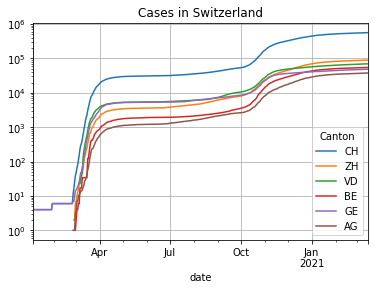

In [61]:
cases[df_summary.index[:6]].reset_index(level=1, drop=True).plot(logy=True, grid=True, title="Cases in Switzerland")

<AxesSubplot:title={'center':'Deaths in Switzerland'}, xlabel='date'>

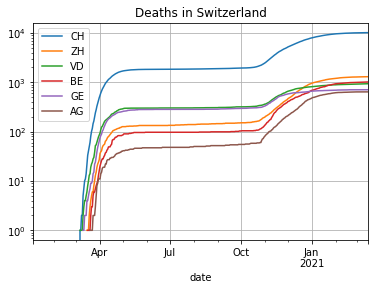

In [62]:
deaths[df_summary.index[:6]].reset_index(level=1, drop=True).plot(logy=True, grid=True, title="Deaths in Switzerland")

# Analysis by Canton

<AxesSubplot:xlabel='date'>

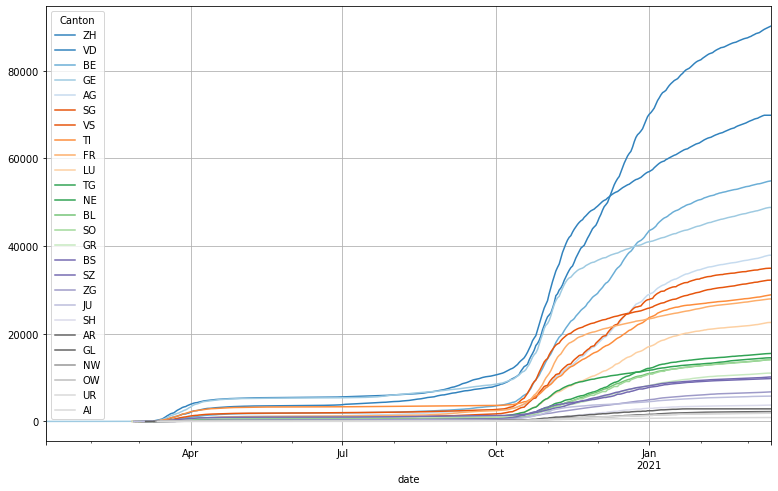

In [63]:
cases[cantons].reset_index(level=1, drop=True).plot(figsize=fig_size, grid=True, cmap=color_scheme1)

In [64]:
# cases[cantons].reset_index(level=0, drop=True).plot(figsize=fig_size, logy=True, logx=True, grid=True, cmap=color_scheme1)

<AxesSubplot:xlabel='date'>

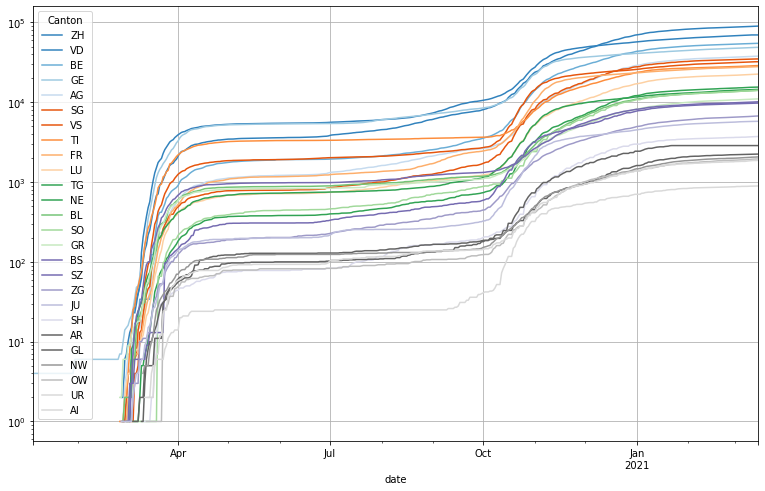

In [65]:
cases[cantons].reset_index(level=1, drop=True).plot(figsize=fig_size, logy=True, grid=True, cmap=color_scheme1)

<AxesSubplot:xlabel='date'>

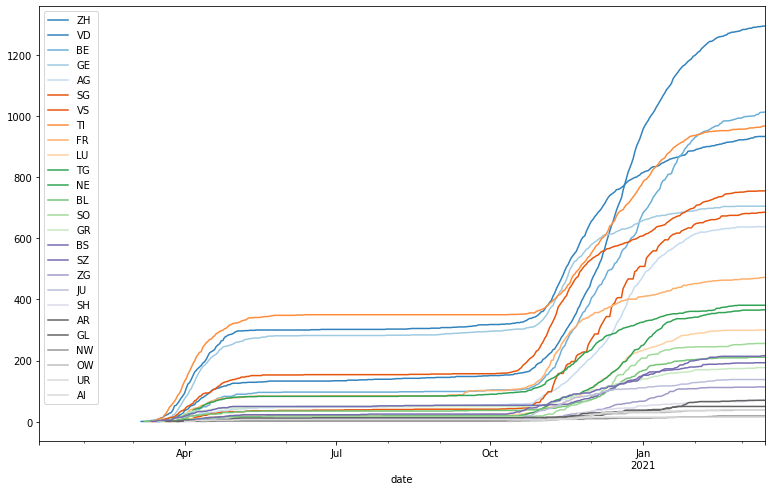

In [66]:
deaths[cantons].reset_index(level=1, drop=True).plot(figsize=fig_size, cmap=color_scheme1)

<AxesSubplot:xlabel='date'>

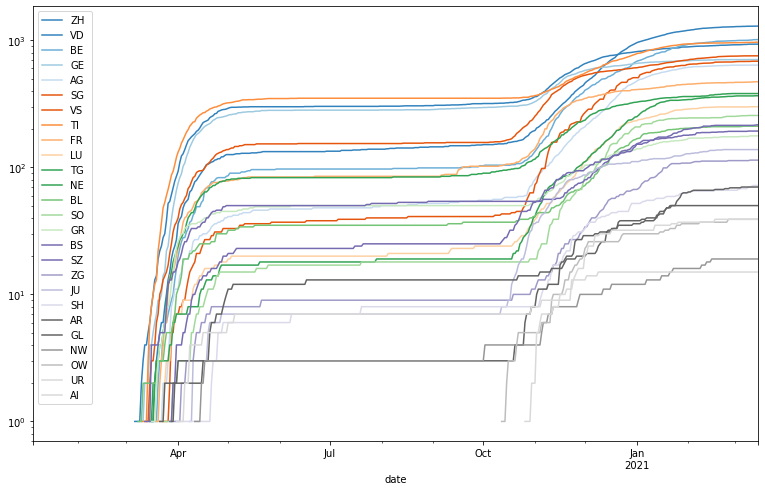

In [67]:
deaths[cantons].reset_index(level=1, drop=True).plot(figsize=fig_size, logy=True, cmap=color_scheme1)

In [68]:
# deaths[cantons].reset_index(level=0, drop=True).plot(figsize=fig_size, logy=True, logx=True, cmap=color_scheme1)

# Switzerland

In [69]:
ch = add(cases, deaths, "CH")

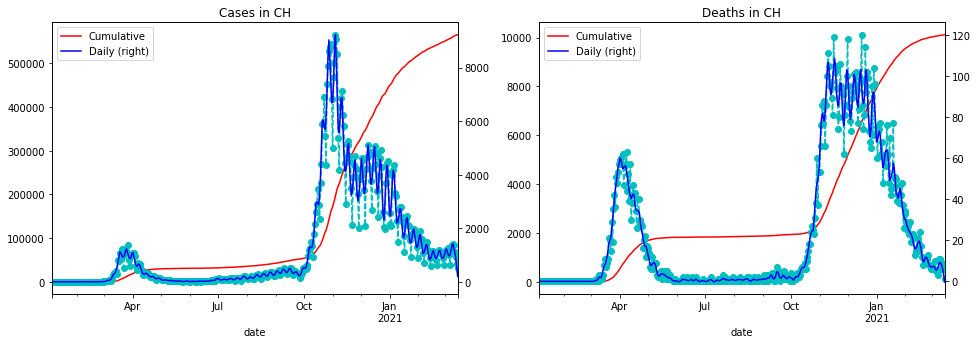

In [70]:
plot_daily(ch)

<AxesSubplot:xlabel='date'>

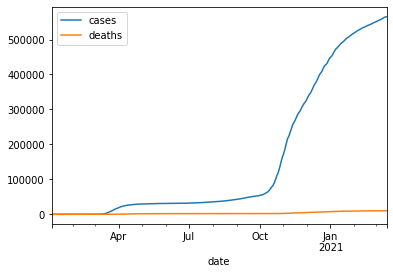

In [71]:
ch[["cases", "deaths"]].reset_index(level=1, drop=True).plot()

<AxesSubplot:xlabel='date'>

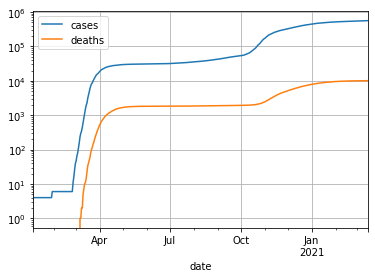

In [72]:
ch[["cases", "deaths"]].reset_index(level=1, drop=True).plot(logy=True, grid=True)

<AxesSubplot:label='2005f0bb-98f8-4bbf-be90-5571caac1609'>

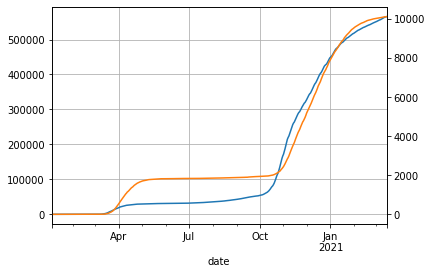

In [73]:
ch["cases"].reset_index(level=1, drop=True).plot(grid=True)
ch["deaths"].reset_index(level=1, drop=True).plot(secondary_y=True, grid=True)

<AxesSubplot:xlabel='cases'>

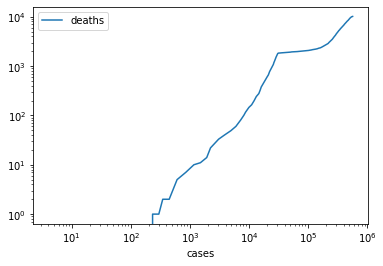

In [74]:
ch.plot(x="cases", y="deaths", logx=True, logy=True)

In [75]:
def plot_correlation_matrix(df):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(df.corr(), cmap="autumn")
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(df.columns, fontsize=12)
    ax.set_yticklabels(df.columns, fontsize=12)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Correlation Matrix")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()


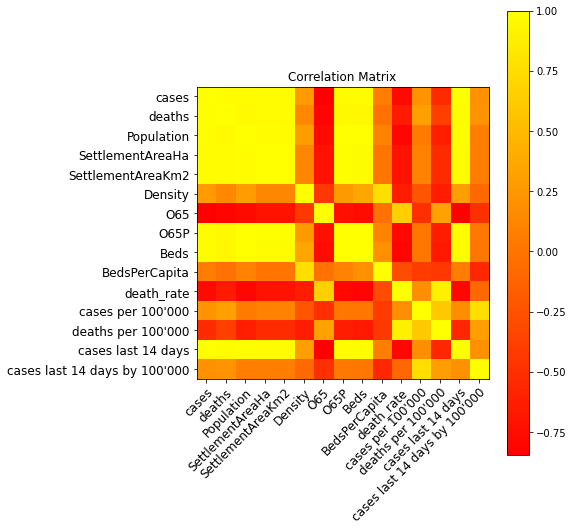

In [76]:
plot_correlation_matrix(df_summary.drop("CH").corr())

In [77]:
corr

,cases,deaths,Population,SettlementAreaHa,SettlementAreaKm2,Density,O65,O65P,Beds,BedsPerCapita,death_rate,cases per 100'000,deaths per 100'000,cases last 14 days,cases last 14 days by 100'000
cases,1.000000,0.938601,0.957008,0.900383,0.900383,0.229894,-0.429916,0.931962,0.940817,0.259324,-0.239964,0.429712,0.055200,0.979781,0.295624
deaths,0.938601,1.000000,0.893126,0.896951,0.896951,0.145066,-0.262697,0.897743,0.893081,0.316770,0.021615,0.511577,0.311153,0.913938,0.353433
Population,0.957008,0.893126,1.000000,0.935437,0.935437,0.224611,-0.338125,0.990900,0.978083,0.245462,-0.262265,0.192048,-0.084221,0.966019,0.165088
SettlementAreaHa,0.900383,0.896951,0.935437,1.000000,1.000000,-0.005266,-0.223024,0.953164,0.897170,0.192998,-0.165343,0.240962,0.020842,0.874466,0.159962
SettlementAreaKm2,0.900383,0.896951,0.935437,1.000000,1.000000,-0.005266,-0.223024,0.953164,0.897170,0.192998,-0.165343,0.240962,0.020842,0.874466,0.159962
Density,0.229894,0.145066,0.224611,-0.005266,-0.005266,1.000000,-0.264201,0.200329,0.324098,0.645255,-0.284540,-0.011736,-0.227672,0.264346,0.120002
O65,-0.429916,-0.262697,-0.338125,-0.223024,-0.223024,-0.264201,1.000000,-0.239242,-0.259050,0.161558,0.369169,-0.338142,0.140221,-0.401917,-0.170042
O65P,0.931962,0.897743,0.990900,0.953164,0.953164,0.200329,-0.239242,1.000000,0.975112,0.268146,-0.217846,0.161409,-0.062376,0.938627,0.149429
Beds,0.940817,0.893081,0.978083,0.897170,0.897170,0.324098,-0.259050,0.975112,1.000000,0.400491,-0.214768,0.188965,-0.050726,0.943868,0.142281
BedsPerCapita,0.259324,0.316770,0.245462,0.192998,0.192998,0.645255,0.161558,0.268146,0.400491,1.000000,0.084013,0.096919,0.116725,0.241414,-0.110482


<AxesSubplot:xlabel='Population', ylabel='cases'>

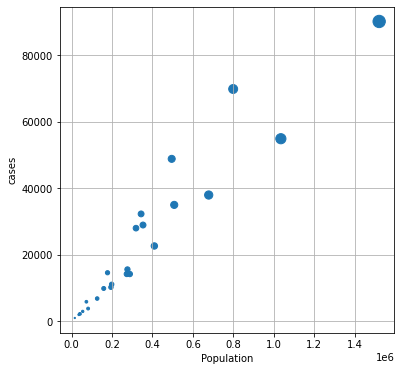

In [78]:
df_summary.iloc[1:].plot.scatter(y="cases", 
                    x="Population", 
                    s=df_summary.iloc[1:]["Population"] / 1e4, 
                    grid=True, figsize=(6, 6))

<AxesSubplot:xlabel="cases per 100'000", ylabel='Density'>

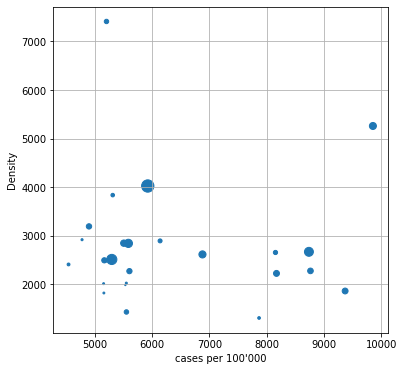

In [79]:
df_summary.iloc[1:].plot.scatter(x="cases per 100'000", 
                    y="Density",  
                    s=df_summary.iloc[1:]["Population"] / 1e4, 
                    grid=True, 
                    figsize=(6, 6))

<AxesSubplot:xlabel="deaths per 100'000", ylabel='Density'>

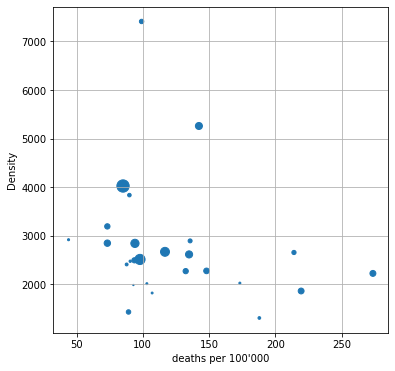

In [80]:
df_summary.iloc[1:].plot.scatter(x="deaths per 100'000", 
                    y="Density", 
                    s=df_summary.iloc[1:]["Population"] / 1e4, 
                    grid=True, 
                    figsize=(6, 6))

<AxesSubplot:xlabel="cases per 100'000", ylabel="deaths per 100'000">

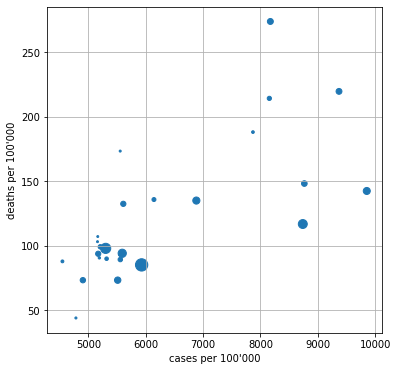

In [81]:
df_summary.iloc[1:].plot.scatter(y="deaths per 100'000", 
                    x="cases per 100'000", 
                    s=df_summary.iloc[1:]["Population"] / 1e4, 
                    grid=True, figsize=(6, 6))

<AxesSubplot:xlabel="cases per 100'000", ylabel="deaths per 100'000">

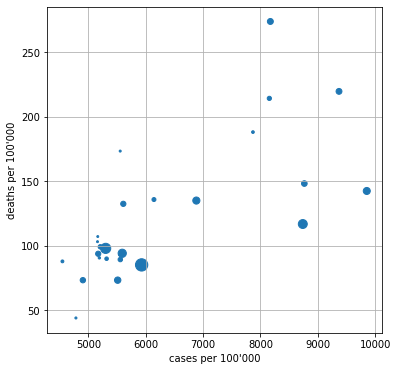

In [82]:
df_summary.iloc[1:].plot.scatter(y="deaths per 100'000", 
                    x="cases per 100'000", 
                    s=df_summary.iloc[1:]["Population"] / 1e4, 
                    grid=True, figsize=(6, 6))

In [83]:
number_of_canton = 15

In [84]:
df_summary["Population"].sort_values(ascending=False)

Canton
CH    8541410
ZH    1520968
BE    1034977
VD     799145
AG     678207
SG     507697
GE     495249
LU     409557
TI     353343
VS     343955
FR     318714
BL     288132
TG     276472
SO     273194
GR     198379
BS     194766
NE     177964
SZ     159165
ZG     126837
SH      81991
JU      73419
AR      55234
NW      43223
GL      40403
OW      37841
UR      36433
AI      16145
Name: Population, dtype: int64

<AxesSubplot:ylabel='Population'>

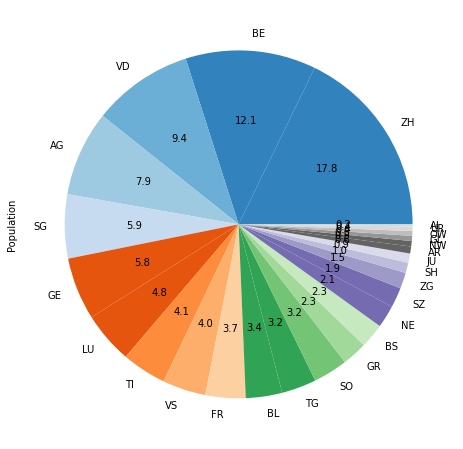

In [85]:
df_summary["Population"].drop("CH").sort_values(ascending=False).plot.pie(figsize=(16, 8), cmap=plt.cm.get_cmap('tab20c'),autopct='%.1f')

In [86]:
canton = pd.concat([df_summary[["cases", "deaths"]].drop("CH").iloc[:number_of_canton], 
                pd.DataFrame([df_summary[["cases", "deaths"]].drop("CH").iloc[number_of_canton:].sum(),])])

In [87]:
canton.rename(index={0: 'others'}, inplace=True)

In [88]:
canton.sort_values(by="cases", ascending=False, inplace=True)

array([<AxesSubplot:ylabel='cases'>, <AxesSubplot:ylabel='deaths'>],
      dtype=object)

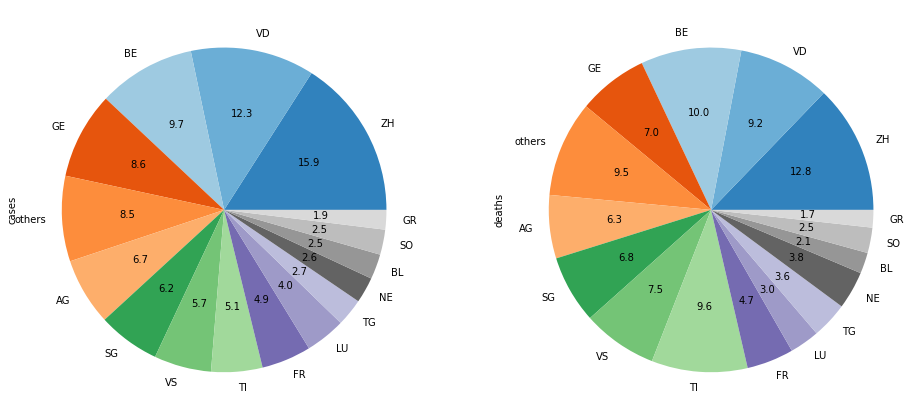

In [89]:
canton.plot.pie(subplots=True, figsize=(16, 8), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')

In [90]:
df_summary.sort_values(by="cases per 100'000", inplace=True, ascending=False)

array([<AxesSubplot:title={'center':"cases per 100'000"}, xlabel='Canton'>,
       <AxesSubplot:title={'center':"deaths per 100'000"}, xlabel='Canton'>],
      dtype=object)

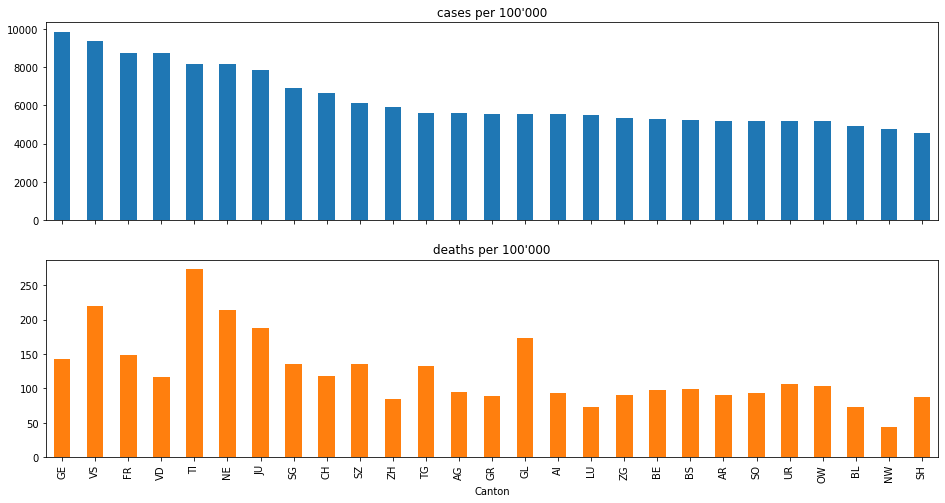

In [91]:
df_summary[["cases per 100'000","deaths per 100'000"]].plot.bar(subplots=True, figsize=(16, 8), legend=False)

array([<AxesSubplot:title={'center':"cases last 14 days by 100'000"}, xlabel='Canton'>],
      dtype=object)

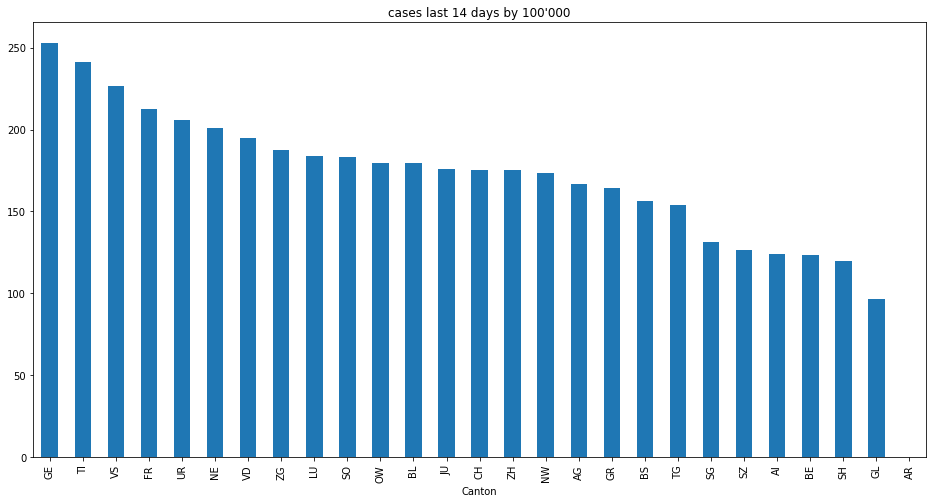

In [92]:
df_summary["cases last 14 days by 100'000"].sort_values(ascending=False).plot.bar(subplots=True, figsize=(16, 8), legend=False)

array([<AxesSubplot:title={'center':'death_rate'}, xlabel='Canton'>],
      dtype=object)

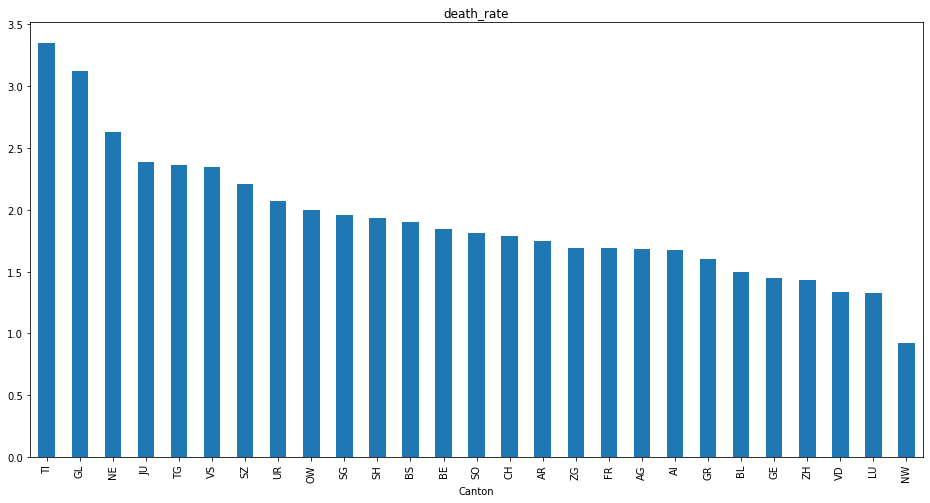

In [93]:
df_summary["death_rate"].sort_values(ascending=False).plot.bar(subplots=True, figsize=(16, 8), legend=False)

In [94]:
# from scipy.optimize import curve_fit

In [95]:
# def logistic(x, l, k, x0):
#     return l / (1 + np.exp(-1 * k * (x -x0)))

In [96]:
# xdata = np.linspace(min(ch.index.get_level_values(1)), max(ch.index.get_level_values(1)), 100)

In [97]:
# max(ch["deaths"])

In [98]:
# [max(ch["deaths"]), 0, 0]

In [99]:
 # [max(ch["deaths"]) *10, 2, 100]

In [100]:
# popt, pcov = curve_fit(logistic, 
#                        ch.index.get_level_values(1).to_numpy(),
#                        ch["deaths"].to_numpy(), 
#                        bounds=([max(ch["deaths"]), 0, 0], [max(ch["deaths"]) *10, 2, 100]))

In [101]:
# popt

In [102]:
# plt.figure(1, figsize=(13, 8))
# plt.scatter(ch.index.get_level_values(1), ch["deaths"], label="Data")
# plt.plot(xdata, logistic(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
# plt.xlabel('Day of year')
# plt.ylabel('deaths')
# plt.grid(True)
# plt.legend()
# plt.show()

In [103]:
# popt

In [104]:
# popt, pcov = curve_fit(logistic, 
#                        ch.index.get_level_values(1).to_numpy(), 
#                        ch["cases"].to_numpy(), 
#                        bounds=([max(ch["cases"]), 0, 0], [max(ch["cases"]) * 10,2, 100]))
# print(popt)
# plt.figure(1, figsize=(13, 8))
# plt.scatter(ch.index.get_level_values(1), 
#             ch["cases"],
#             label="Data")
# plt.plot(xdata, logistic(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
# plt.xlabel('Days')
# plt.ylabel('cases')
# plt.grid(True)
# plt.legend()
# plt.show()

In [105]:
# pcov

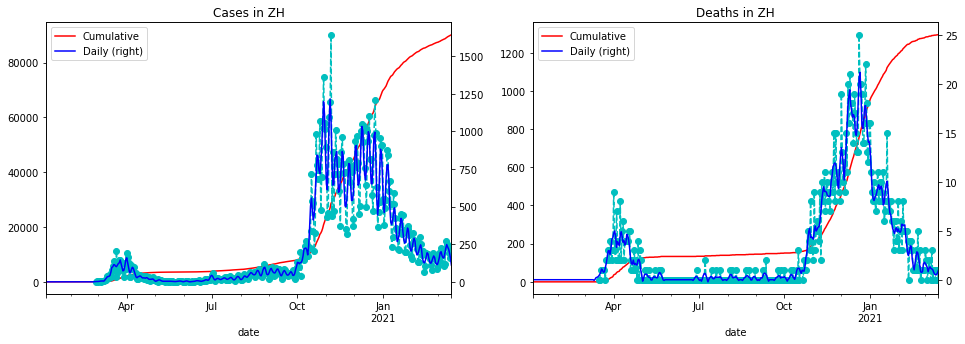

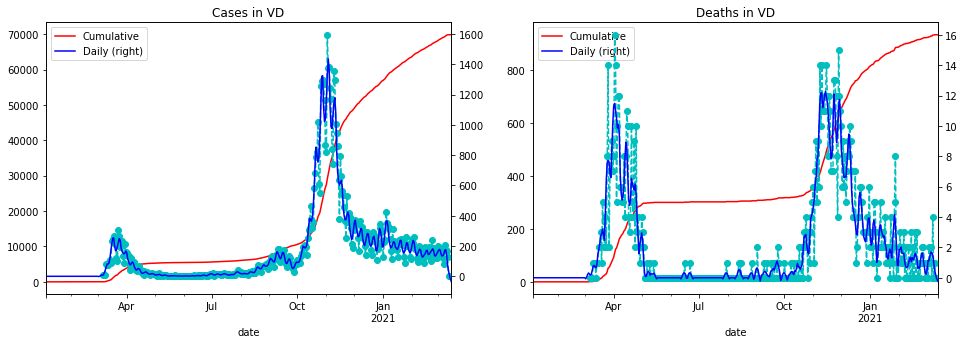

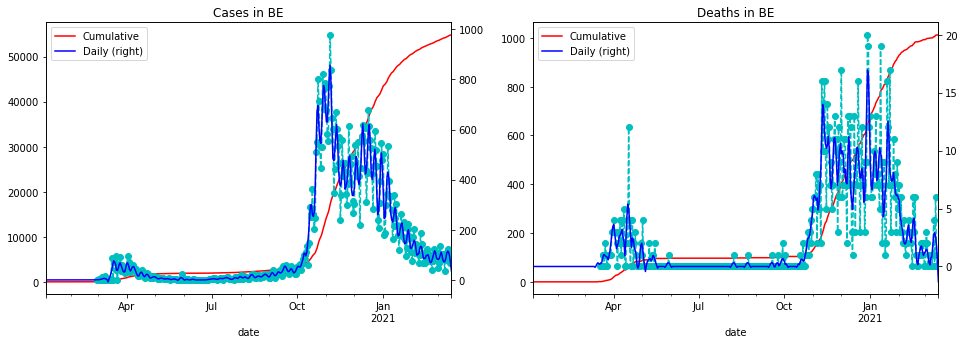

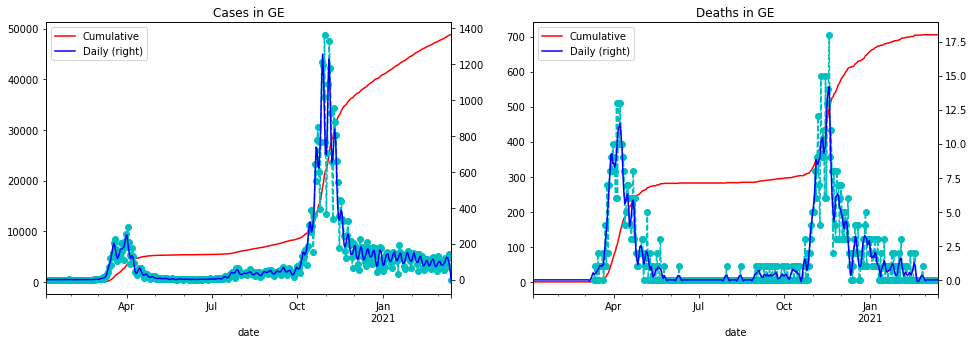

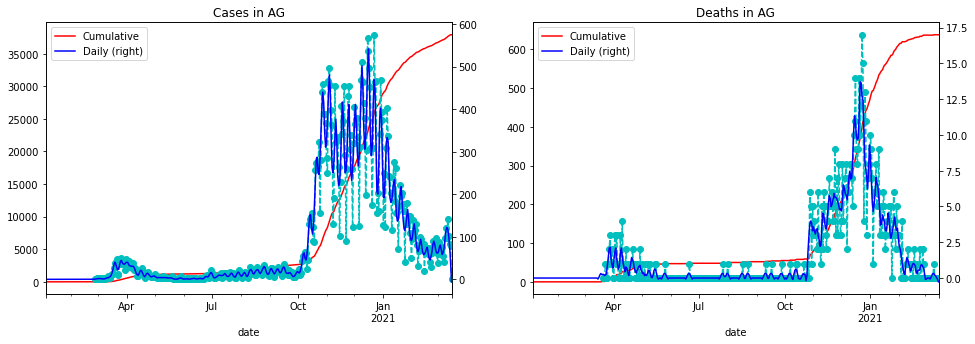

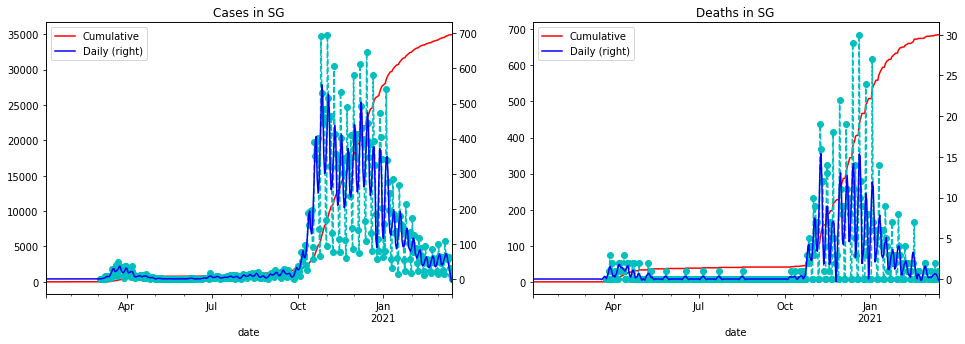

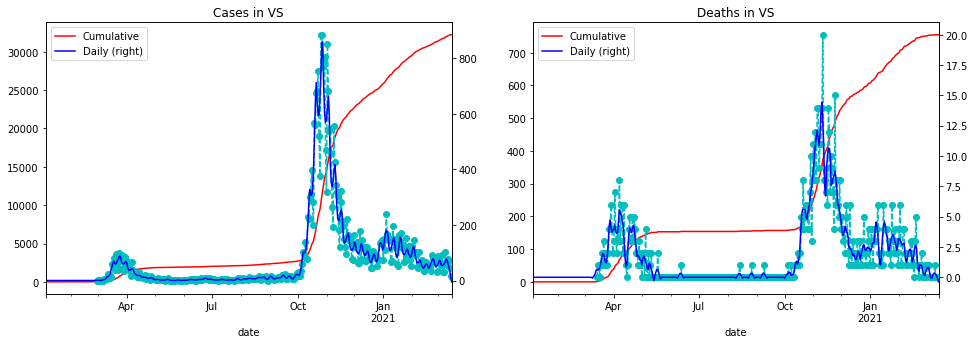

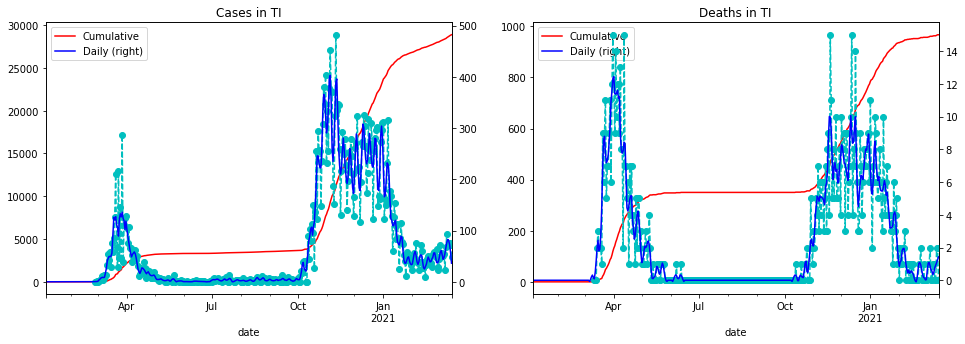

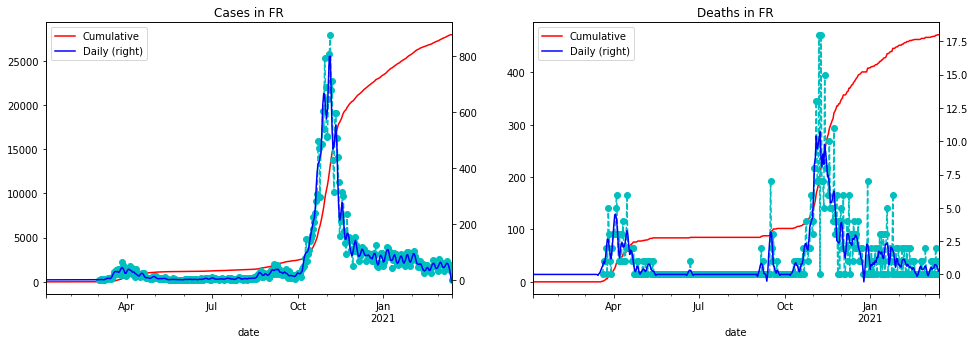

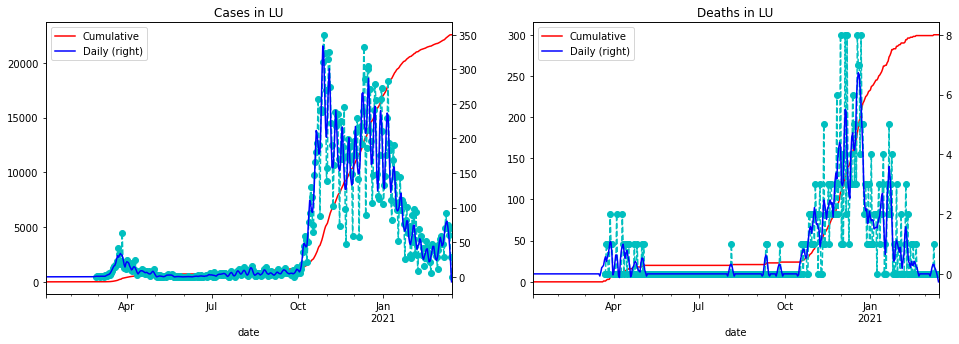

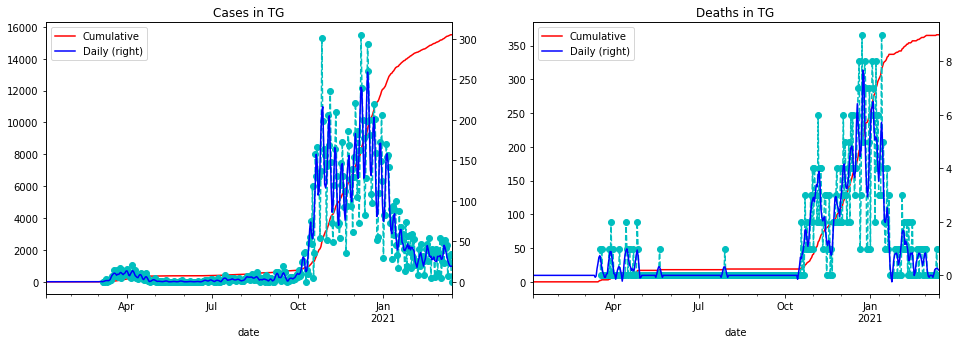

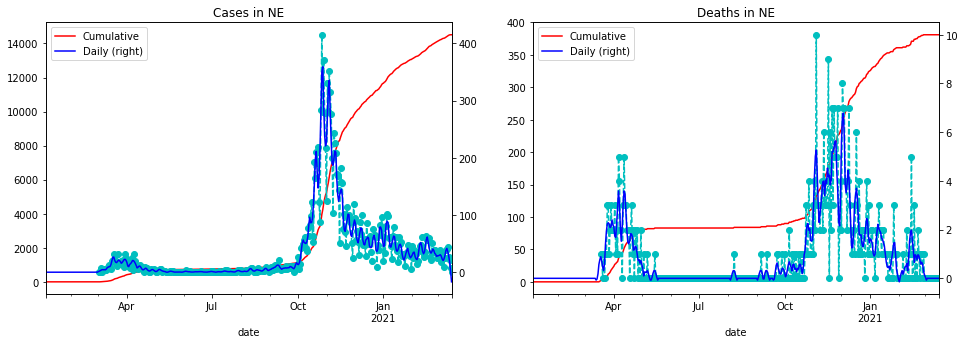

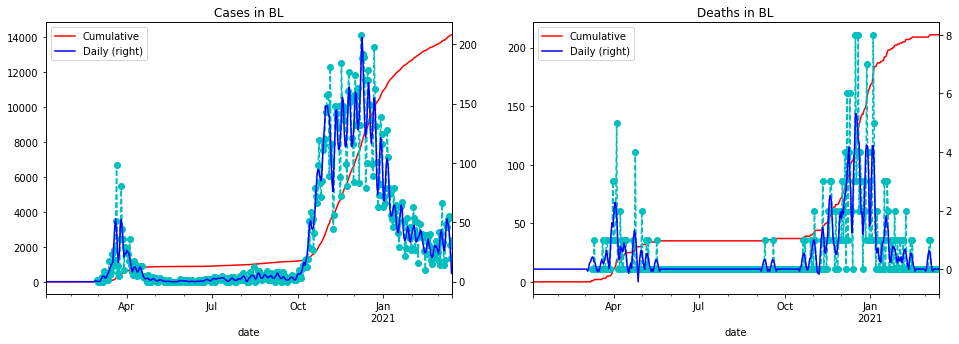

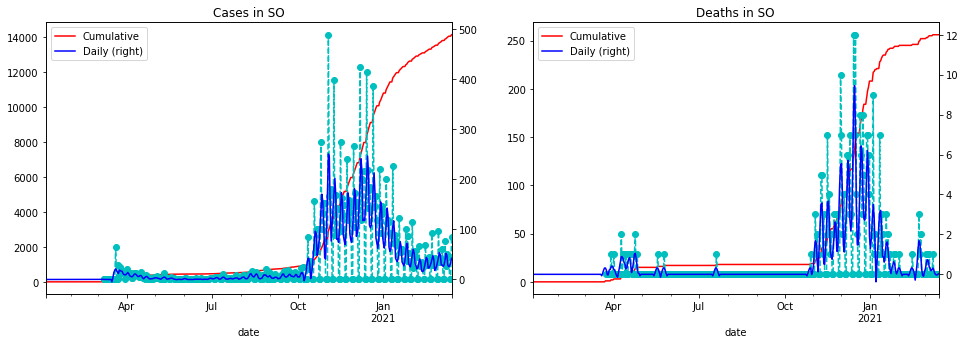

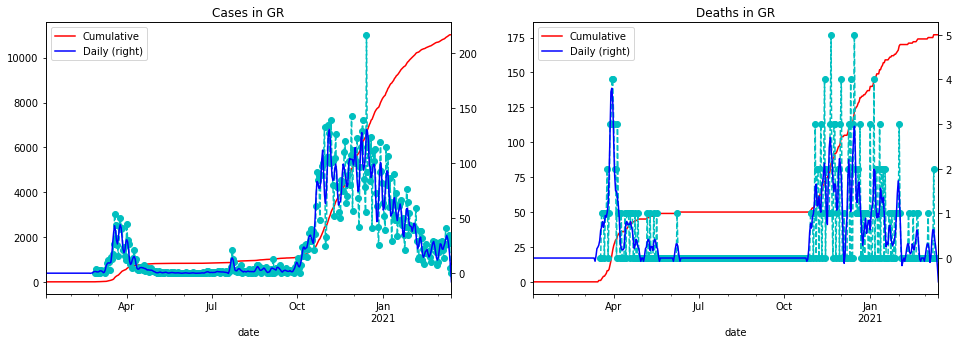

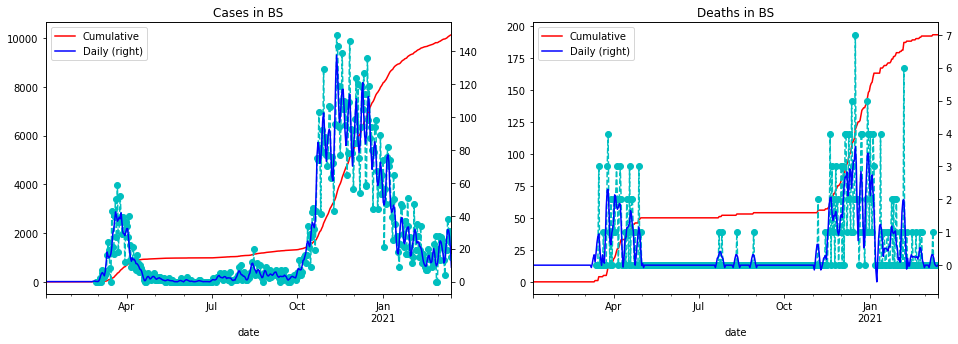

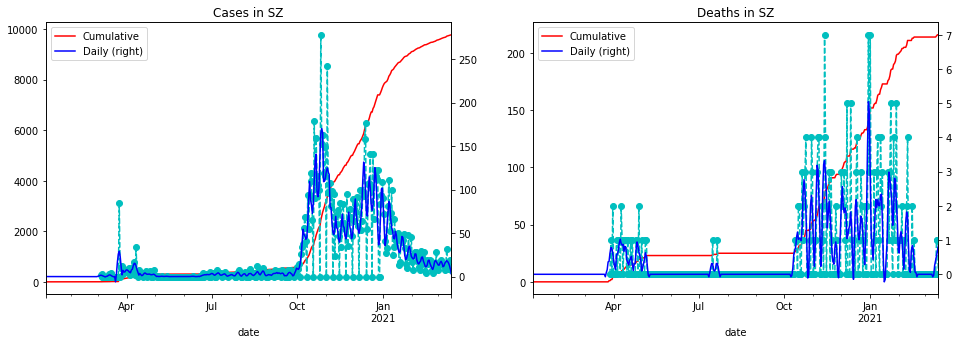

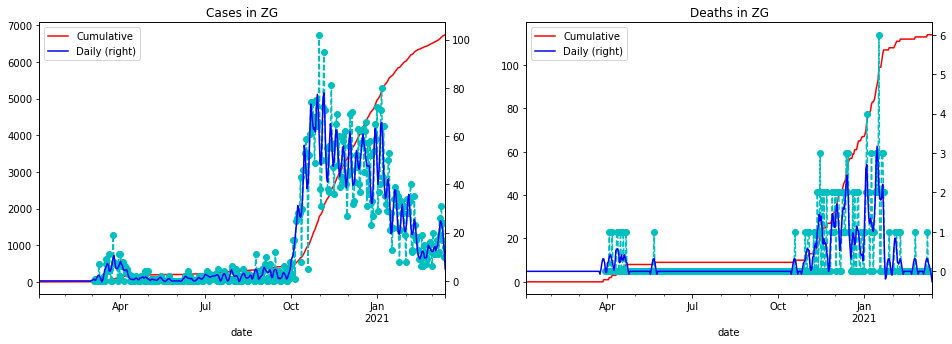

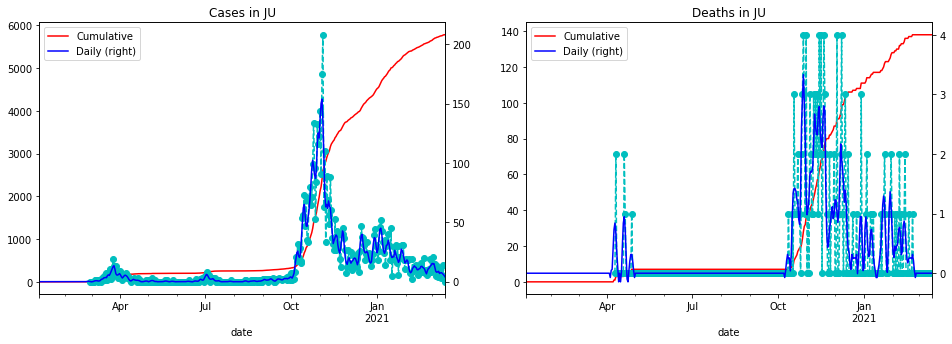

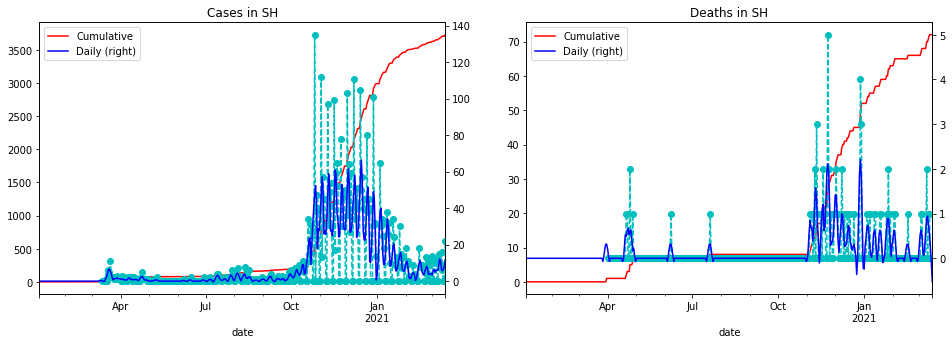

In [ ]:
for c in cantons:
    df_c = add(cases, deaths, c)
    plot_daily(df_c)
    plt.show()

# Hospitalization

In [ ]:
hosp_total = hosp['CH']

In [ ]:
# hosp_total.reset_index("day_of_year", drop=True, inplace=True)

In [ ]:
hosp_total.plot(title="Hospitalization in Switzerland",figsize=(16,9))

In [ ]:
for c in cantons:
    h = hosp[c]
    #h.reset_index("day_of_year", drop=True, inplace=True)
    h.plot(title=f"Hospitalization in {c}",figsize=(8,4.5))
    plt.show()

# ICU

In [ ]:
icu_ch = icu['CH']
icu_ch.plot(title="Persons in ICU in Switzerland",figsize=(16,9))

In [ ]:
for c in cantons:
    i = icu[c]
    #h.reset_index("day_of_year", drop=True, inplace=True)
    i.plot(title=f"ICU in {c}",figsize=(8,4.5))
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
for c in cantons[:10]:
    df_c = add(cases, deaths, c)
    df_c.plot(x="cases", y="deaths", ax=ax, logx=True, logy=True, label=c)
    # plt.show()

In [ ]:
df_c